In [1]:
# Загружаем библиотеки
import nltk # Обработка естественного языка
import pandas as pd # Датафреймы pandas
import bz2 # Сжатие в формате bz2
import json # Сжатие в формате json
import re # Регулярные выражения
import nltk # Обработка естественного языка
from nltk.corpus import stopwords # Стоп-слова
import pymorphy2 # Морфологический анализатор
import matplotlib.pyplot as plt # Построение графиков
from nltk import word_tokenize # Токенизация текста
from nltk.probability import FreqDist # Анализ частоты встречаемости
from gensim.corpora import Dictionary # Словари
from gensim.models import TfidfModel # Модель TF-IDF
from gensim.models import lsimodel # Модель LSA
from sklearn.model_selection import train_test_split # Разделение выборки на обучающую и тестовую
from sklearn.feature_extraction.text import CountVectorizer # Векторизация слов
from sklearn.ensemble import RandomForestClassifier # Модель случайного леса
from sklearn.feature_extraction.text import TfidfTransformer # Преобразование TF-IDF
from sklearn.pipeline import Pipeline # Последовательности преобразований
from sklearn.decomposition import TruncatedSVD # Семантический анализ
from sklearn.decomposition import LatentDirichletAllocation # Анализ LDA

#### Загрузка и предобработка данных

In [2]:
# Читаем отзывы и записываем в список в виде словарей
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in thefile:
        resp = json.loads(row)
        # Проверяем наличие оценки и текста отзыва
        if not resp['rating_not_checked'] and resp['rating_grade'] != None and (len(resp['text'].split()) > 0):
            responses.append(resp)

In [4]:
# Преобразуем в датафрейм
data = pd.DataFrame.from_dict(responses)

In [5]:
# Выделим все слова, состоящие из русских и латинских букв,
# приведём к нижнему регистру
words = re.compile("[a-zA-Zа-яёА-ЯË]+")
def words_only(text):
    return " ".join(words.findall(text)).lower()

# Результат записываем в отдельный столбец
data['text_words_only'] = data['text'].apply(words_only)

In [6]:
# Удалим стоп-слова
mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д', 'г',
    'который', 'прошлый', 'сей', 'свой', 'наш', 'мочь', 'такой'
]

def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

data['text_words_no_stop'] = data['text_words_only'].apply(remove_stopwords)    

In [7]:
# Приведём все слова к простым формам
m = pymorphy2.MorphAnalyzer()
def lemmatize(text):
    try:
        return  " ".join([m.parse(w)[0].normal_form for w in text.split()])
    except:
        return " "
    
data['text_lemmatize'] = data['text_words_no_stop'].apply(lemmatize)      

In [2]:
# Сохраним результат для ускорения работы
# data.to_csv('data.csv')
# data = pd.read_csv('data.csv')

### Часть 1

#### Задание 1.1

In [12]:
# Есть ошибки в варианты написания городов, их нужно исправлять, это трудоёмко и в поставленную задачу не входит
data.groupby(['city', 'bank_name']).agg({'text': 'count'}).head()

,,text
city,bank_name,
г. ...,Авангард,1
г. ....,Авангард,1
г. 112422,Хоум Кредит Банк,1
"г. 143420 Московская область, Красногорский район, посёлок дачного хозяйства Архангельское, д.4,кв.2",Банк Москвы,1
г. 2-я Гавриловка,Сбербанк России,1


#### Задание 1.2

In [13]:
# В Slack было уточнение, что нужно считать длины СООБЩЕНИЙ в символах и в словах

In [14]:
# Перебираем отзывы и считаем количество символов в каждом
char_count = {}
for text in data['text']:
    try:
        char_count[len(text)] += 1
    except:
        char_count[len(text)] = 1

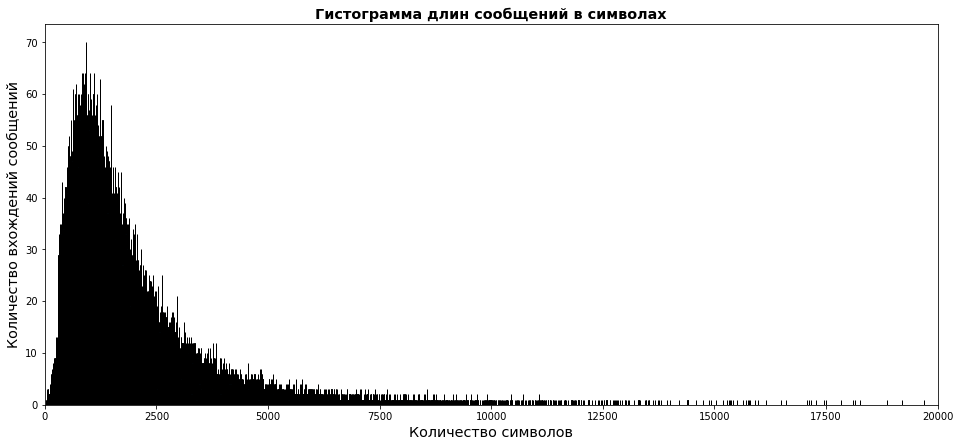

In [15]:
# Гистограмма длин сообщений в символах
plt.figure(figsize = (16, 7))
plt.bar(char_count.keys(), char_count.values(), edgecolor = 'black')
plt.xlim(0, 20000)
plt.title('Гистограмма длин сообщений в символах', fontsize = 'x-large', fontweight = 'bold')
plt.xlabel('Количество символов', fontsize = 'x-large')
plt.ylabel('Количество вхождений сообщений', fontsize = 'x-large')

plt.show()

In [16]:
# Перебираем отзывы и считаем количество слов
word_count = {}
for text in data['text_words_only']:
    try:
        word_count[len(text.split())] += 1
    except:
        word_count[len(text.split())] = 1

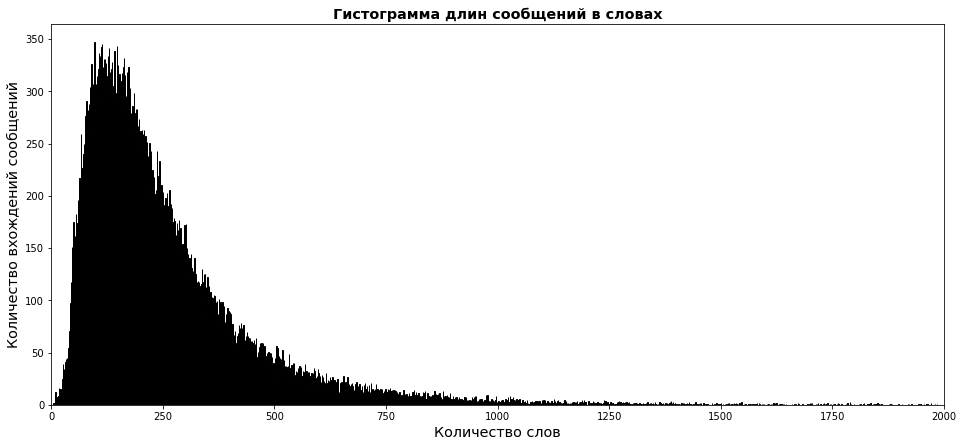

In [17]:
# Гистограмма длин сообщений в словах
plt.figure(figsize = (16, 7))
plt.bar(word_count.keys(), word_count.values(), edgecolor = 'black')
plt.xlim(0, 2000)
plt.title('Гистограмма длин сообщений в словах', fontsize = 'x-large', fontweight = 'bold')
plt.xlabel('Количество слов', fontsize = 'x-large')
plt.ylabel('Количество вхождений сообщений', fontsize = 'x-large')

plt.show()

#### Задание 1.3

In [18]:
# Анализ частоты встречаемости слов

# Соединим все сообщения в один большой текст
all_words = []
for text in data['text_words_only']:
    all_words += text.split()
    
fdist = FreqDist(all_words)
print('10 самых частых слов:', end = ' ')
for word in fdist.most_common(10):
    print(word[0], end = ', ')

10 самых частых слов: в, и, не, на, что, я, с, по, мне, банка, 

In [19]:
# Соединим все сообщения без стоп-слов в один большой текст
all_words_no_stop = []
for text in data['text_words_no_stop']:
    all_words_no_stop += text.split()

fdist = FreqDist(all_words_no_stop)
print('10 самых частых слов без стоп-слов:', end = ' ')
for word in fdist.most_common(10):
    print(word[0], end = ', ')

10 самых частых слов без стоп-слов: банка, банк, деньги, карту, карты, отделение, день, кредит, банке, заявление, 

In [20]:
# Соединим все сообщения из лемм в один большой текст
all_words_lemmatize = []
for text in data['text_lemmatize']:
    all_words_lemmatize += text.split()

fdist = FreqDist(all_words_lemmatize)
print('10 самых частых лемм:', end = ' ')
for word in fdist.most_common(10):
    print(word[0], end = ', ')

10 самых частых лемм: банк, карта, деньга, день, отделение, мой, счёт, кредит, сотрудник, клиент, 

In [21]:
# Размечаем части речи
all_words_lemmatize_tagged = nltk.pos_tag(all_words_lemmatize, lang = 'rus')

In [22]:
# Отбираем существительные с тегом 'S' и записываем их в отдельный список
nouns = []
for word in all_words_lemmatize_tagged:
    if word[1] == 'S':
        nouns.append(word[0])

In [23]:
fdist = FreqDist(nouns)
print('10 самых частых существительных:', end = ' ')
for word in fdist.most_common(10):
    print(word[0], end = ', ')

10 самых частых существительных: банк, карта, день, деньга, отделение, счёт, сотрудник, клиент, кредит, заявление, 

#### Задание 1.4

In [24]:
# Определяем частоту встречаемости лемм
fdist = FreqDist(all_words_lemmatize)

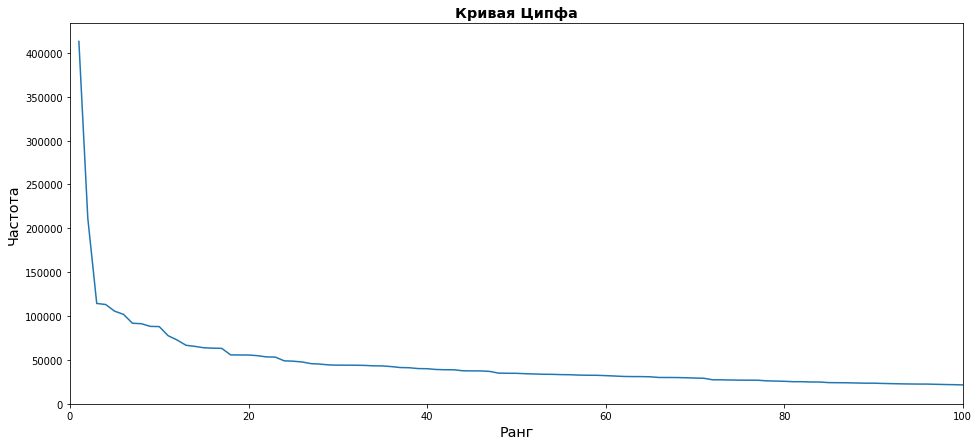

In [25]:
# График Ципфа
plt.figure(figsize=(16, 7))
plt.plot(range(1, len(fdist) + 1), sorted(fdist.values(), reverse = True))
plt.xlim(0, 100)
plt.ylim(0)
plt.title('Кривая Ципфа', fontsize = 'x-large', fontweight = 'bold')
plt.xlabel('Ранг', fontsize = 'x-large')
plt.ylabel('Частота', fontsize = 'x-large')

plt.show()

In [26]:
# Создаём словарь в который записываем количество отзывов и количество слов в них
heaps = {}
# Проходим от одного до 1000 отзывов (для максимального количества отзывов работает слишком долго)
for text_number in range(1, 1000):
    # Объединяем тексты нужного количества отзывов и считаем количество одинаковых слов
    text = data['text_words_only'][0:(text_number)].sum()
    heaps[text_number] = len(set(text.split()))

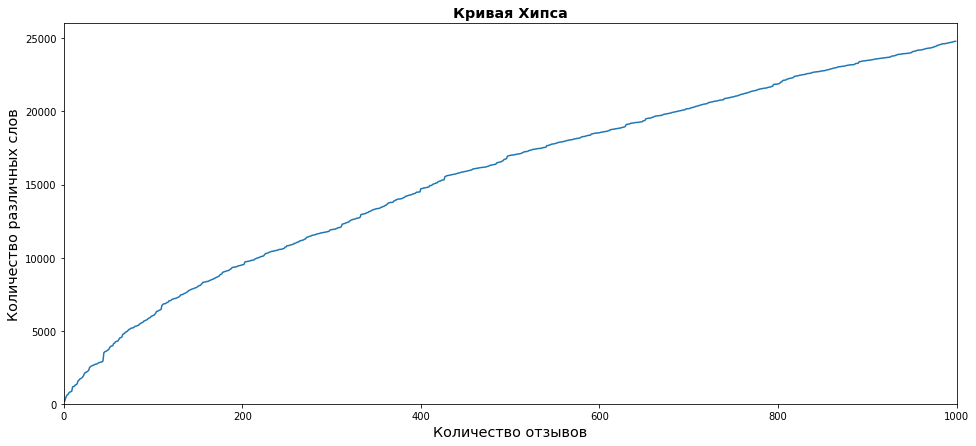

In [27]:
# График Хипса
plt.figure(figsize=(16, 7))
plt.plot(range(1, len(heaps) + 1), sorted(heaps.values()))
plt.xlim(0, 1000)
plt.ylim(0)
plt.title('Кривая Хипса', fontsize = 'x-large', fontweight = 'bold')
plt.xlabel('Количество отзывов', fontsize = 'x-large')
plt.ylabel('Количество различных слов', fontsize = 'x-large')

plt.show()

#### Задание 1.5

In [28]:
print('Какое слово встречается чаще, "сотрудник" или "клиент"?')
print('- среди всех форм слов: ', end = '')
fdist = FreqDist(all_words)
if fdist['сотрудник'] > fdist['клиент']:
    print('сотрудник')
else:
    print('клиент')

print('- среди лемм: ', end = '')
fdist = FreqDist(all_words_lemmatize)
if fdist['сотрудник'] > fdist['клиент']:
    print('сотрудник')
else:
    print('клиент')

Какое слово встречается чаще, "сотрудник" или "клиент"?
- среди всех форм слов: сотрудник
- среди лемм: сотрудник


In [29]:
print('Сколько раз встречается слова "мошенничество" и "доверие"?')
fdist = FreqDist(all_words)
print(f'- среди всех форм слов: мошенничество {fdist["мошенничество"]}, доверие {fdist["доверие"]}')

fdist = FreqDist(all_words_lemmatize)
print(f'- среди лемм: мошенничество {fdist["мошенничество"]}, доверие {fdist["доверие"]}')

Сколько раз встречается слова "мошенничество" и "доверие"?
- среди всех форм слов: мошенничество 493, доверие 699
- среди лемм: мошенничество 1299, доверие 1259


#### Задание 1.6

In [62]:
# Объединим все отзывы в список слов
texts_list = [text.split() for text in data['text_lemmatize']]

In [33]:
# Создаём словари
dictionary = Dictionary(texts_list)
corpus = [dictionary.doc2bow(text) for text in texts_list]

In [7]:
# Модель TF-IDF
tfidf = TfidfModel(corpus)

In [8]:
# Объединим все отзывы с оценкой 5 в один список
texts_5 = []
for text in data[data['rating_grade'] == 5]['text_lemmatize']:
    texts_5 += text.split()
corpus_5 = dictionary.doc2bow(texts_5)

In [9]:
# Считаем значимость слов и сортируем по значимости
words_5 = tfidf[corpus_5]
words_5.sort(key = lambda x: x[1], reverse = True)

In [10]:
# Берём наиболее встречающиеся ключевые слова
print('Ключевые слова для положительных отзывов: ', end = '')
for word, score in words_5[:5]:
    print(dictionary[word], end = ', ')

Ключевые слова для положительных отзывов: вклад, очень, карта, кредит, спасибо, 

In [11]:
# Аналогично, для отзывов с оценкой 1
texts_1 = []
for text in data[data['rating_grade'] == 1]['text_lemmatize']:
    texts_1 += text.split()
corpus_1 = dictionary.doc2bow(texts_1)
words_1 = tfidf[corpus_1]
words_1.sort(key = lambda x: x[1], reverse = True)
print('Ключевые слова для отрицательных отзывов: ', end = '')
for word, score in words_1[:5]:
    print(dictionary[word], end = ', ')

Ключевые слова для отрицательных отзывов: карта, кредит, заявление, счёт, деньга, 

In [12]:
# Получим биграммы для всех сообщений
bigram_list = []
for text in texts_list:
    bigram = [' '.join([word_0, word_1]) for word_0, word_1 in nltk.bigrams(text)]
    bigram_list += [bigram]

In [13]:
# Создаём словари
dictionary_bigram = Dictionary(bigram_list)
corpus_bigram = [dictionary_bigram.doc2bow(text) for text in bigram_list]

In [14]:
# Модель TF-IDF
tfidf_bigram = TfidfModel(corpus_bigram)

In [27]:
# Получим биграммы отзывов с оценкой 5
texts_bigram_5 = [' '.join([word_0, word_1]) for word_0, word_1 in nltk.bigrams(texts_5)]
corpus_bigram_5 = dictionary_bigram.doc2bow(texts_bigram_5)

In [29]:
bigram_5 = tfidf[corpus_bigram_5]
bigram_5.sort(key = lambda x: x[1], reverse = True)
print('Ключевые биграммы для положительных отзывов: ', end = '')
for word, score in bigram_5[:5]:
    print(dictionary_bigram[word], end = ', ')

Ключевые биграммы для положительных отзывов: интернет банк, сотрудник банк, следующий день, дебетовый карта, другой банк, 

In [30]:
# Аналогично, для отзывов с оценкой 1
texts_bigram_1 = [' '.join([word_0, word_1]) for word_0, word_1 in nltk.bigrams(texts_1)]
corpus_bigram_1 = dictionary_bigram.doc2bow(texts_bigram_1)
bigram_1 = tfidf[corpus_bigram_1]
bigram_1.sort(key = lambda x: x[1], reverse = True)
print('Ключевые биграммы для отрицательных отзывов: ', end = '')
for word, score in bigram_1[:5]:
    print(dictionary_bigram[word], end = ', ')

Ключевые биграммы для отрицательных отзывов: сотрудник банк, отделение банк, досрочный погашение, колл центр, кредитный договор, 

In [ ]:
# С моей точки зрения, результат неверный. Где-то ошибка.
# Полученные слова и биграммы не характеризуют всю совокупность отрицательных и положительных отзывов, 
# некоторые из них встречаются как для положительных, так и для отрицательных отзывов.

### Часть 2

#### Задание 2.1

In [34]:
# Латентно-семантический анализ LSA
corpus_tfidf = tfidf[corpus]

In [56]:
lsi_8 = lsimodel.LsiModel(corpus = corpus_tfidf, id2word = dictionary, num_topics = 8)
lsi_8.show_topics(8)

[(0,
  '0.191*"карта" + 0.130*"кредит" + 0.110*"деньга" + 0.110*"заявление" + 0.109*"вклад" + 0.106*"счёт" + 0.105*"банкомат" + 0.098*"отделение" + 0.091*"сумма" + 0.090*"сбербанк"'),
 (1,
  '0.593*"вклад" + 0.166*"очередь" + -0.159*"кредит" + 0.140*"открыть" + -0.137*"заявление" + -0.133*"платёж" + -0.122*"задолженность" + -0.108*"погашение" + 0.094*"депозит" + 0.093*"офис"'),
 (2,
  '-0.380*"кредит" + 0.365*"банкомат" + 0.269*"карта" + -0.215*"страховка" + -0.172*"договор" + 0.159*"сбербанк" + -0.144*"погашение" + 0.140*"деньга" + 0.128*"операция" + -0.126*"страхование"'),
 (3,
  '-0.303*"вклад" + 0.287*"карта" + -0.249*"банкомат" + 0.238*"заявка" + -0.186*"сумма" + -0.160*"платёж" + -0.157*"деньга" + -0.146*"погашение" + -0.137*"средство" + -0.129*"руб"'),
 (4,
  '-0.344*"банкомат" + 0.343*"карта" + 0.258*"вклад" + -0.145*"очередь" + 0.129*"задолженность" + -0.122*"заявка" + 0.116*"комиссия" + -0.116*"терминал" + -0.116*"купюра" + -0.114*"кредит"'),
 (5,
  '-0.287*"вклад" + -0.260*"

Интерпретация тем:
- 0 - Получение кредитных и дебетовых карт в отделениях в Сбербанка
- 1 - Очереди на открытие депозитов в офисе банка
- 2 - Операции по картам в банкоматах Сбербанка
- 3 - Заявка на погашение долга по карте
- 4 - Комиссии на погашение задолженности по карте
- 5 - Комиссия за платежи в банкомате
- 6 - Оформление страхования через банкомат с использованием карты
- 7 - Услуги перевода по номеру телефона через терминалы Киви 

In [61]:
# Анализ с разбиением на 3 темы по результатам очень похож на предыдущий анализ с разбиением на 8 тем
lsi_3 = lsimodel.LsiModel(corpus = corpus_tfidf, id2word = dictionary, num_topics = 3)
lsi_3.show_topics(3)

[(0,
  '0.191*"карта" + 0.131*"кредит" + 0.110*"заявление" + 0.110*"деньга" + 0.109*"вклад" + 0.106*"счёт" + 0.105*"банкомат" + 0.098*"отделение" + 0.091*"сумма" + 0.090*"сбербанк"'),
 (1,
  '0.569*"вклад" + -0.201*"кредит" + 0.165*"очередь" + -0.142*"платёж" + -0.139*"заявление" + 0.136*"открыть" + -0.126*"погашение" + -0.126*"задолженность" + -0.103*"страховка" + -0.097*"руб"'),
 (2,
  '0.395*"банкомат" + -0.352*"кредит" + -0.257*"страховка" + 0.237*"карта" + -0.174*"договор" + 0.162*"сбербанк" + -0.152*"страхование" + 0.146*"деньга" + 0.127*"операция" + -0.127*"документ"')]

#### Задание 2.2

In [86]:
for topic in lsi_8.show_topics(8):
    num, words = topic
    if 'сбербанк' in words:
        print(words)
    if 'киви' in words:
        print(words)        

0.191*"карта" + 0.130*"кредит" + 0.110*"деньга" + 0.110*"заявление" + 0.109*"вклад" + 0.106*"счёт" + 0.105*"банкомат" + 0.098*"отделение" + 0.091*"сумма" + 0.090*"сбербанк"
-0.380*"кредит" + 0.365*"банкомат" + 0.269*"карта" + -0.215*"страховка" + -0.172*"договор" + 0.159*"сбербанк" + -0.144*"погашение" + 0.140*"деньга" + 0.128*"операция" + -0.126*"страхование"
-0.287*"вклад" + -0.260*"сбербанк" + -0.212*"заявление" + 0.171*"банкомат" + -0.158*"заявка" + -0.151*"рассмотрение" + 0.131*"комиссия" + 0.130*"платёж" + -0.128*"денежный" + -0.128*"обращение"
-0.250*"карта" + 0.227*"перевод" + -0.202*"банкомат" + 0.175*"терминал" + -0.166*"заявление" + 0.153*"кошелёк" + 0.146*"услуга" + 0.142*"киви" + 0.129*"номер" + 0.123*"qiwi"


Темы относящиеся к Сбербанку упоминают кредиты, вклады, использование карт и банкоматов, а относящиеся к Киви - переводы денег по номеру телефона.

### Часть 3

#### Задание 3.1

In [3]:
# Множества отзывов с оценками 1 и 5, делаем множества равными для сбалансированности классов
N1 = N2 = 10000
data_N1 = data[data['rating_grade'] == 1][['text_lemmatize', 'rating_grade']].head(N1)
data_N2 = data[data['rating_grade'] == 5][['text_lemmatize', 'rating_grade']].head(N2)
data_all = pd.concat([data_N1, data_N2])
# Перемешиваем строки случайным образом
data_all = data_all.sample(frac = 1, random_state = 42)
# Отбрасываем старые индексы
data_all = data_all.reset_index(drop=True)
# Пусть положительные отзывы будут обозначены 1, а отрицательные 0
data_all['rating_grade'] = data_all['rating_grade'].replace(to_replace = 1, value = 0)
data_all['rating_grade'] = data_all['rating_grade'].replace(to_replace = 5, value = 1)

In [4]:
# Разбиваем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(data_all['text_lemmatize'], data_all['rating_grade'], random_state = 42)  

#### Задание 3.2

In [5]:
# Преобразование текста в векторы
vectorizer_uni = CountVectorizer()
# Признаки
X = vectorizer_uni.fit_transform(data_all['text_lemmatize'])
# Целевые значения
y = data_all['rating_grade']

In [6]:
# Разбиваем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42) 

In [7]:
# Используем модель случайного леса
model_forest_uni = RandomForestClassifier(n_estimators = 10, random_state = 42)
model_forest_uni.fit(X_train, y_train)
print(f'Точность классификации с использованием отдельных слов составляет {model_forest_uni.score(X_test, y_test)}')

Точность классификации с использованием отдельных слов составляет 0.8808


In [8]:
# Преобразование текста в векторы с использованием биграмм
vectorizer_bi = CountVectorizer(ngram_range = (1, 2))
X = vectorizer_bi.fit_transform(data_all['text_lemmatize'])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42) 
model_forest_bi = RandomForestClassifier(n_estimators = 10, random_state = 42)
model_forest_bi.fit(X_train, y_train)
print(f'Точность классификации с использованием отдельных слов и биграмм составляет {model_forest_bi.score(X_test, y_test)}')

Точность классификации с использованием отдельных слов и биграмм составляет 0.8634


In [10]:
# Преобразование текста в векторы с использованием триграмм
vectorizer_tri = CountVectorizer(ngram_range = (1, 3))
X = vectorizer_tri.fit_transform(data_all['text_lemmatize'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42) 
model_forest_tri = RandomForestClassifier(n_estimators = 10, random_state = 42)
model_forest_tri.fit(X_train, y_train)
print(f'Точность классификации с использованием отдельных слов, биграмм и триграмм составляет {model_forest_tri.score(X_test, y_test)}')

Точность классификации с использованием отдельных слов, биграмм и триграмм составляет 0.8586


В данном случае использование биграмм и триграмм не даёт выигрыша в точности классификации. Для сравнения в дальнейшем используем показатель качества модели с использование отдельных слов, который составляет 0,88.

#### Задание 3.3

In [11]:
# Преобразование текста в векторы
vectorizer = CountVectorizer()
vect = vectorizer.fit_transform(data_all['text_lemmatize'])
# Признаки Tfidf
tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(vect)

In [12]:
# Латентый семантический анализ
svd = TruncatedSVD(n_components = 25, n_iter = 10 , random_state = 42)
X = svd.fit_transform(tfidf)

In [13]:
# Целевые значения
y = data_all['rating_grade']
# Разбиваем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42) 

In [14]:
# Классификация
model_forest = RandomForestClassifier(n_estimators = 10, random_state = 42)
model_forest.fit(X_train, y_train)
print(f'Точность классификации с использованием TF-IDF и SVD составляет {model_forest.score(X_test, y_test)}')

Точность классификации с использованием TF-IDF и SVD составляет 0.8824


In [23]:
# Латентное размещение Дирихле
lda = LatentDirichletAllocation(n_components = 25, random_state = 42)

In [24]:
X = lda.fit_transform(vect)

In [27]:
# Разбиваем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42) 
model_forest = RandomForestClassifier(n_estimators = 10, random_state = 42)
model_forest.fit(X_train, y_train)
print(f'Точность классификации с использованием LDA составляет {model_forest.score(X_test, y_test)}')

Точность классификации с использованием LDA составляет 0.8994


В данном случае наилучшую точность классификации обеспечивает LDA!